In [12]:
import copy
from dataclasses import dataclass
import datetime
import typing as T

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

from IPython.display import display
import ipywidgets as widgets

## Setup

In [2]:
from_date = widgets.DatePicker()
to_date = widgets.DatePicker()
print('From date:')
display(from_date)
print('To date:')
display(to_date)

From date:


DatePicker(value=None)

To date:


DatePicker(value=None)

## Visualisation & utility functions

In [31]:
def pivot_to_hm(df):
    dates = sorted(df.dt.unique())
    df_hm = pd.DataFrame(index=sorted(df.h.unique()))
    for date in dates:
        dt_col = pd.to_datetime(date).date().isoformat().replace('-', '_')
        df_sub = df[df.dt == date].set_index('h').SpotPriceDKK.to_frame(dt_col)
        df_sub[dt_col] = df_sub[dt_col] / 1000.0
        df_hm = df_hm.join(df_sub)
    return df_hm

In [33]:
def spot_heatmap(df, annot=True):
    df_plot = pivot_to_hm(df)
    sns.heatmap(df_plot, annot=annot, cmap='RdYlGn_r', fmt='.3g')
    plt.show()

## Classes

### Battery

In [3]:
@dataclass
class Charge:
    charged_kWh: float
    consumed_kWh: float
    cost: float

@dataclass
class Discharge:
    discharged_kWh: float
    delivered_kWh: float
    cost: float

@dataclass
class SimpleBattery:
    # cost (depreciation) to charge 1 kWh
    charge_cost_kWh: float = .3
    # cost (depreciation) to discharge 1 kWh
    discharge_cost_kWh: float  = 0.0
    # charge remaining in battery
    remaining_kWh: float  = 0.0
    # maximum capacity in kWh
    capacity_kWh: float  = 5.0
    # maximum kWh charged per hour
    max_charge_kWh: float = 1
    # maximum kWh discharged per hour
    max_discharge_kWh: float = 1
    # charge conversion loss in percent
    charge_loss: float = 0.07
    # discharge conversion loss in percent
    discharge_loss: float = 0.07
        
    def charge(self, network_kWh=np.inf):
        """
        charge the battery for one time unit
        """
        remaining_capacity_kWh = self.capacity_kWh - self.remaining_kWh
        consumed_kWh = min(network_kWh, self.max_charge_kWh, remaining_capacity_kWh)
        charged_kWh = consumed_kWh * (1 - self.charge_loss)

        self.remaining_kWh += charged_kWh
        cost = charged_kWh * self.charge_cost_kWh
        return Charge(charged_kWh=charged_kWh, consumed_kWh=consumed_kWh, cost=cost)
    
    def discharge(self, network_kWh=np.inf):
        """
        charge the battery for one time unit
        """
        discharged_kWh = min(
            self.remaining_kWh, 
            self.max_discharge_kWh,
            network_kWh * (1+self.discharge_loss)
        )
        delivered_kWh = discharged_kWh * (1 - self.discharge_loss)
        cost = discharged_kWh * self.discharge_cost_kWh
        self.remaining_kWh -= discharged_kWh
        return Discharge(discharged_kWh=discharged_kWh, delivered_kWh=delivered_kWh, cost=cost)
    
    def noop(self):
        """
        let the battery chill for one time unit
        """
        pass

### Market

In [59]:
@dataclass
class MarketState:
    current_ts: np.datetime64
    price_area: int
    past_spot_dkk: np.ndarray
    past_ts: np.ndarray
    future_spot_dkk: np.ndarray
    future_ts: np.ndarray
        
def download_nordpool_data(from_date, to_date, price_area='DK2'):
    url = (
            f"https://api.energidataservice.dk/dataset/Elspotprices/download?"
            f"format=XL&offset=0&start={from_date}T00:00&end={to_date}T00:00"
            f"&filter=%7B%22PriceArea%22:%22{price_area}%22%7D&sort=HourDK%20DESC&timezone=dk"
    )
    df = pd.read_excel(url)
    df['dt'] = df.HourDK.dt.date
    df['h'] = df.HourDK.dt.hour
    return df


def market_states(df, past_window=7, future_window=2, round_days=True):
    df = df.copy()
    area_groups = df.groupby('PriceArea')
    for price_area, g in area_groups:
        g = g.sort_values(by='HourDK')
        n = len(g) - (past_window + future_window) + 1
        for i in range(n):
            now = i+past_window
            past = g.iloc[now-past_window:now]
            future = g.iloc[now: now+future_window]
            current_ts = g.iloc[now, :].HourDK.to_pydatetime()
            yield MarketState(
                current_ts=current_ts,
                price_area=price_area,
                past_spot_dkk=past.SpotPriceDKK.values,
                past_ts=past.HourDK.values,
                future_spot_dkk=future.SpotPriceDKK.values,
                future_ts=future.HourDK.values,
            )

### Environment

In [ ]:
class Environment:
    
    def __init__(self, battery, nordpool_df, repeat=1):
        self._battery_orig = copy.deepcopy(battery)
        self._nordpool_orig = nordpool_df.copy()
        self._battery = None
        self._msg = None
    
    def reset(self):
        

    
    
    

## Load data

In [23]:
#df = download_nordpool_data(from_date.value, to_date.value)
#df.to_csv('../data/nordpool_2022_Q3.csv', index=False)
df = pd.read_csv('../data/nordpool_2022_Q3.csv', parse_dates=['HourUTC', 'HourDK', 'dt'])
#df.HourUTC = pd.to_datetime(df.HourUTC)
#df.HourDK = pd.to_datetime(df.HourDK)
#df.dt = pd.to_datetime(df.dt).dt.date
df.head()

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR,dt,h
0,2022-09-29 21:00:00,2022-09-29 23:00:00,DK2,2784.679932,374.459991,2022-09-29,23
1,2022-09-29 20:00:00,2022-09-29 22:00:00,DK2,2952.530029,397.029999,2022-09-29,22
2,2022-09-29 19:00:00,2022-09-29 21:00:00,DK2,3160.449951,424.989990,2022-09-29,21
3,2022-09-29 18:00:00,2022-09-29 20:00:00,DK2,3867.000000,520.000000,2022-09-29,20
4,2022-09-29 17:00:00,2022-09-29 19:00:00,DK2,4499.100098,605.000000,2022-09-29,19


In [32]:
pivot_to_hm(df[df.dt > '2022-09-20'])

,2022_09_21,2022_09_22,2022_09_23,2022_09_24,2022_09_25,2022_09_26,2022_09_27,2022_09_28,2022_09_29
0,2.30756,2.77416,2.62164,2.81037,1.99775,1.84985,1.41990,2.27861,2.61357
1,2.22784,2.52387,2.38123,2.55889,1.71028,1.33736,1.34026,2.05076,2.50247
2,2.22754,2.45449,2.32435,2.32026,1.60052,1.16626,1.26263,1.82887,2.42535
3,2.22784,2.31216,2.23437,2.28457,1.59993,0.90154,1.12506,1.80686,2.34392
4,2.21074,2.39589,2.25400,2.27758,1.44555,0.73036,1.24441,2.03582,2.37969
5,2.53542,2.67697,2.41351,2.32554,1.46935,1.15942,1.56133,2.28389,2.56954
6,3.17548,3.23542,3.05367,2.56692,1.69644,1.81877,2.43513,2.84934,3.27259
7,3.97670,3.98594,3.38554,2.76457,1.78389,2.48280,3.09300,3.51459,4.23830
8,3.92434,3.70910,3.15711,2.75624,2.07271,2.45380,3.29793,3.72094,4.33877
9,3.17615,2.88429,2.79609,2.78963,2.16833,2.16759,3.06578,3.19691,3.55615


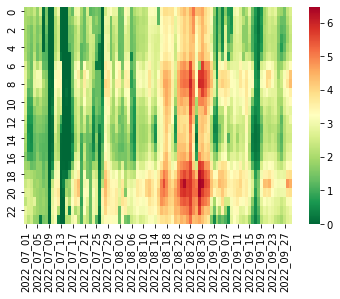

In [34]:
spot_heatmap(df, annot=False)

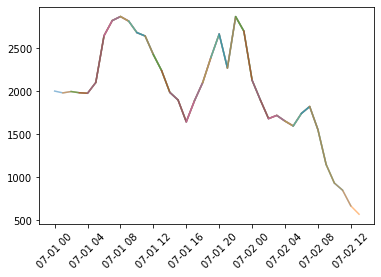

In [69]:
for i, state in enumerate(market_states(df)):
    sns.lineplot(x=state.past_ts, y=state.past_spot_dkk, alpha=0.5)
    if i > 30: break

plt.xticks(rotation = 45)
plt.show()

In [72]:
pivot_to_hm(download_nordpool_data('2022-10-01', '2022-10-07'))

,2022_10_01,2022_10_02,2022_10_03,2022_10_04,2022_10_05,2022_10_06
0,0.47895,0.47993,0.60114,1.52798,0.33455,0.00692
1,0.47285,0.47621,0.69929,1.40239,0.61966,0.00290
2,0.37180,0.43308,0.61660,1.39554,0.40237,0.00067
3,0.15972,0.46067,0.62664,1.25745,0.34236,0.00060
4,0.12574,0.44014,0.70799,1.39569,0.31217,0.00045
5,0.11176,0.44267,0.94402,1.46433,0.30964,0.00431
6,0.11169,0.44156,1.43279,2.45371,0.71491,0.14981
7,0.17727,0.44639,2.08167,3.17896,1.10918,0.37013
8,0.33477,0.63229,2.26133,3.69867,1.15669,0.43306
9,0.54320,0.68412,1.80713,2.35793,0.77983,0.31233
